## Importaciones

In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager
from utils.common import load_data, Data


SELECTED_DATA= Data.FIRST_3000

## Cargar Dataset

In [2]:
df = load_data(SELECTED_DATA)

# print("Dataset creado:")

# # Ver las dimensiones del DataFrame (filas y columnas)
# print(f"Dimensiones del DataFrame: {df.shape}")

# # Ver los nombres de las columnas y sus tipos de datos
# print("\nInformación del DataFrame:")
# display(df.info())  # display() para mejor presentación en notebooks
# # Mostrar las primeras filas del DataFrame
# print("\nPrimeras 5 filas del DataFrame:")
# display(df.head(75))  # Mejor presentación en notebook

# # # Verificar si hay valores nulos por columna
# # print("\nValores nulos por columna:")
# # print(df.isnull().sum())

# # # Resumen estadístico de los datos numéricos
# print("\nResumen estadístico:")
# display(df.describe())

# top_users = df["uid"].value_counts().head(10)
# print("Usuarios más activos:\n", top_users)

In [3]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


## Preprocesamiento y Creación de Secuencias

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn


# Crear secuencias de 7 días por usuario
def create_week_sequences(data, seq_length=7):
    """
    Genera secuencias de 7 días para predecir las coordenadas del siguiente día.
    Maneja datos faltantes llenando días incompletos con ceros.
    """
    X, y = [], []
    users = data["uid"].unique()
    for uid in users:
        user_data = data[data["uid"] == uid]
        days = sorted(user_data["d"].unique())  # Ordenar los días únicos

        # Rellenar días faltantes
        complete_data = []
        for day in days:
            day_data = user_data[user_data["d"] == day]
            if len(day_data) < 48:
                # Crear DataFrame con todos los timeslots (completos en ceros)
                filled_day = pd.DataFrame({"t": range(48), "x": 0, "y": 0})

                # Realizar un merge para combinar con los valores de day_data
                filled_day = pd.merge(
                    filled_day, day_data[["t", "x", "y"]], on="t", how="left"
                )

                # Reemplazar NaN con 0 en las columnas faltantes
                filled_day["x"] = filled_day["x_y"].fillna(filled_day["x_x"])
                filled_day["y"] = filled_day["y_y"].fillna(filled_day["y_x"])

                # Limpiar las columnas no deseadas
                filled_day = filled_day[["t", "x", "y"]]

                # Añadir columnas adicionales
                filled_day["d"] = day
                filled_day["uid"] = uid

                # Ordenar por 't' y añadir a complete_data
                complete_data.append(
                    filled_day.sort_values(by="t").reset_index(drop=True)
                )
            else:
                # Si ya tiene todos los timeslots, simplemente ordenar y añadir
                complete_data.append(
                    day_data.sort_values(by="t").reset_index(drop=True)
                )

        complete_data = pd.concat(complete_data).reset_index(drop=True)

        # Crear secuencias de 7 días
        for i in range(len(days) - seq_length):
            # Seleccionar los días de la ventana
            week_days = days[i : i + seq_length]
            next_day = days[i + seq_length]

            # Extraer datos correspondientes a la ventana de 7 días
            seq = complete_data[complete_data["d"].isin(week_days)]
            target = complete_data[complete_data["d"] == next_day]

            if len(seq) == seq_length * 48 and len(target) == 48:
                X.append(seq[["x", "y"]].values)
                y.append(target[["x", "y"]].values)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return torch.tensor(X), torch.tensor(y)


# Dividir datos por rango de días
def split_data_by_days(df):
    train = df[df["d"] < 44]  # Días de entrenamiento
    val = df[(df["d"] >= 44) & (df["d"] < 60)]  # Días de validación
    test = df[df["d"] >= 60]  # Días de prueba
    return train, val, test


# Normalización
def normalize_data(train, val, test):
    scaler = MinMaxScaler()

    # Agregar explícitamente un valor cero al conjunto de entrenamiento para garantizar su mapeo correcto
    numerical_cols = ["x", "y"]
    zero_padding = pd.DataFrame({col: [0.0] for col in numerical_cols})

    train = pd.concat([train, zero_padding], ignore_index=True)
    train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
    val[numerical_cols] = scaler.transform(val[numerical_cols])
    test[numerical_cols] = scaler.transform(test[numerical_cols])

    # Eliminar el valor cero añadido del conjunto de entrenamiento
    train = train.iloc[:-1].reset_index(drop=True)

    return train, val, test, scaler



# Dataset personalizado
class WeekDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Preparación de datos
df_train, df_val, df_test = split_data_by_days(df)
df_train, df_val, df_test = df_train.copy(), df_val.copy(), df_test.copy()
df_train, df_val, df_test, scaler = normalize_data(df_train, df_val, df_test)

# Crear secuencias
seq_length = 7
X_train, y_train = create_week_sequences(df_train, seq_length)
X_val, y_val = create_week_sequences(df_val, seq_length)
X_test, y_test = create_week_sequences(df_test, seq_length)

# Datasets y DataLoaders
train_dataset = WeekDataset(X_train, y_train)
val_dataset = WeekDataset(X_val, y_val)
test_dataset = WeekDataset(X_test, y_test)

dataloader_params = {"batch_size": 64, "shuffle": True}
train_loader = DataLoader(train_dataset, **dataloader_params)
val_loader = DataLoader(val_dataset, **dataloader_params)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Modelos


In [5]:
# Modelo de red neuronal
class SimpleNN(nn.Module):
    def __init__(
        self,
        input_size=2,
        hidden_size=64,
        output_size=2,
        seq_length=7,
        timeslots_per_day=48,
    ):
        super(SimpleNN, self).__init__()
        self.seq_length = seq_length
        self.timeslots_per_day = timeslots_per_day
        self.output_size = output_size * timeslots_per_day

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_length * timeslots_per_day * input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, self.output_size),
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(-1, self.timeslots_per_day, 2)

## Función de Entrenamiento

In [6]:
def masked_mse_loss(output, target):
    """
    Calcula la pérdida MSE ignorando los valores (0, 0) en las coordenadas.

    Args:
        output (torch.Tensor): Predicciones del modelo.
        target (torch.Tensor): Valores reales.

    Returns:
        loss (torch.Tensor): Pérdida promedio ignorando datos faltantes.
    """
    # Crear máscara para excluir los valores (0, 0)
    mask = (target != 0).any(dim=-1)  # Mantener si al menos una coordenada no es 0
    output_masked = output[mask]
    target_masked = target[mask]

    # Calcular MSE en los datos no faltantes
    loss = nn.MSELoss()(output_masked, target_masked)
    return loss


def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, device="cpu"):
    """
    Función para entrenar el modelo con evaluación en validación y guardar el mejor modelo.

    Args:
        model: Instancia del modelo a entrenar.
        train_loader: DataLoader con los datos de entrenamiento.
        val_loader: DataLoader con los datos de validación.
        epochs (int): Número de épocas.
        lr (float): Tasa de aprendizaje.
        device (str): Dispositivo para entrenamiento ("cpu" o "cuda").

    Returns:
        history (dict): Diccionario con pérdidas de entrenamiento y validación por época.
        best_model (torch.nn.Module): Modelo con el mejor rendimiento en validación.
        best_epoch (int): Época donde se obtuvo el mejor modelo.
    """
    # Criterio de pérdida (Error Cuadrático Medio para regresión)
    criterion = masked_mse_loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Mover el modelo al dispositivo (CPU o GPU)
    model.to(device)

    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float("inf")
    best_model_state = None
    best_epoch = -1

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        total_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            # Mover datos al dispositivo
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validación
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Mover datos al dispositivo
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Guardar pérdidas
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        # Actualizar el mejor modelo si la pérdida de validación mejora
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            best_epoch = epoch

        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}"
        )

    # Cargar el mejor modelo
    best_model = model
    best_model.load_state_dict(best_model_state)

    return history, best_model, best_epoch

## Entrenamiento y Gráficas Comparativas

Epoch [1/100], Train Loss: 0.0247, Val Loss: 0.0119
Epoch [2/100], Train Loss: 0.0142, Val Loss: 0.0121
Epoch [3/100], Train Loss: 0.0129, Val Loss: 0.0104
Epoch [4/100], Train Loss: 0.0122, Val Loss: 0.0114
Epoch [5/100], Train Loss: 0.0116, Val Loss: 0.0106
Epoch [6/100], Train Loss: 0.0112, Val Loss: 0.0098
Epoch [7/100], Train Loss: 0.0109, Val Loss: 0.0103
Epoch [8/100], Train Loss: 0.0106, Val Loss: 0.0097
Epoch [9/100], Train Loss: 0.0104, Val Loss: 0.0097
Epoch [10/100], Train Loss: 0.0103, Val Loss: 0.0101
Epoch [11/100], Train Loss: 0.0101, Val Loss: 0.0106
Epoch [12/100], Train Loss: 0.0100, Val Loss: 0.0099
Epoch [13/100], Train Loss: 0.0100, Val Loss: 0.0104
Epoch [14/100], Train Loss: 0.0098, Val Loss: 0.0097
Epoch [15/100], Train Loss: 0.0098, Val Loss: 0.0099
Epoch [16/100], Train Loss: 0.0097, Val Loss: 0.0095
Epoch [17/100], Train Loss: 0.0096, Val Loss: 0.0095
Epoch [18/100], Train Loss: 0.0095, Val Loss: 0.0093
Epoch [19/100], Train Loss: 0.0095, Val Loss: 0.0095
Ep

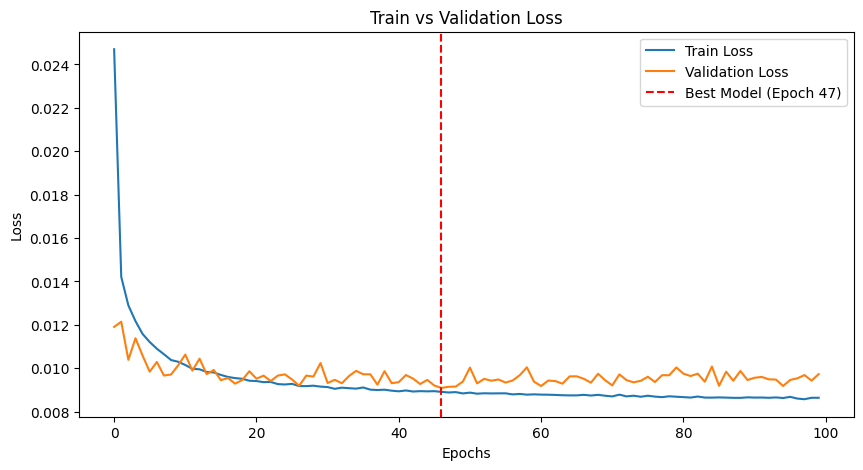

In [7]:
# Entrenar el modelo
model = SimpleNN(input_size=2, hidden_size=64, output_size=2, seq_length=7, timeslots_per_day=48)
losses, best_model, best_epoch = train_model(model, train_loader, val_loader, epochs=100, lr=0.001, device=device)

# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(losses["train_loss"], label="Train Loss")
plt.plot(losses["val_loss"], label="Validation Loss")
plt.axvline(best_epoch, color="red", linestyle="--", label=f"Best Model (Epoch {best_epoch+1})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()


In [8]:
# Ruta al modelo guardado
model_path = "../Data/Models/simple_nn_complete.pth"
torch.save(model, model_path)

print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")
print(f"Mejor modelo guardado desde la época {best_epoch+1}")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.
Mejor modelo guardado desde la época 47


In [9]:
import numpy as np
import torch

def evaluate_model(model, test_loader, scaler, numerical_cols):
    """
    Evalúa el modelo y calcula métricas en datos desnormalizados, excluyendo valores faltantes (0, 0),
    pero manteniendo las dimensiones originales.

    Args:
        model: Modelo entrenado.
        test_loader: DataLoader con los datos de prueba.
        scaler: Instancia de MinMaxScaler para desnormalización.
        numerical_cols: Columnas numéricas para desnormalizar.

    Returns:
        results (dict): Métricas (MSE, MAE) y predicciones desnormalizadas con dimensiones consistentes.
    """
    model.eval()  # Configurar el modelo en modo evaluación
    total_mse = 0.0
    total_mae = 0.0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            # Mover datos al dispositivo
            batch_X, batch_y = batch_X.to(next(model.parameters()).device), batch_y.to(next(model.parameters()).device)

            # Predicciones del modelo
            outputs = model(batch_X)

            # Desnormalizar las predicciones y los objetivos
            batch_size, timeslots, features = outputs.shape
            outputs_np = outputs.cpu().numpy().reshape(-1, features)
            batch_y_np = batch_y.cpu().numpy().reshape(-1, features)

            outputs_denorm = scaler.inverse_transform(outputs_np).reshape(batch_size, timeslots, features)
            targets_denorm = scaler.inverse_transform(batch_y_np).reshape(batch_size, timeslots, features)

            # Crear máscara para excluir valores (0, 0)
            mask = (targets_denorm != 0).any(axis=-1).reshape(batch_size, timeslots)

            # Reemplazar valores excluidos con NaN
            outputs_with_nan = np.full_like(outputs_denorm, np.nan)
            targets_with_nan = np.full_like(targets_denorm, np.nan)

            outputs_with_nan[mask] = outputs_denorm[mask]
            targets_with_nan[mask] = targets_denorm[mask]

            # Calcular métricas excluyendo los NaN
            valid_mask = ~np.isnan(targets_with_nan)
            mse_loss = np.mean((outputs_with_nan[valid_mask] - targets_with_nan[valid_mask]) ** 2)
            mae_loss = np.mean(np.abs(outputs_with_nan[valid_mask] - targets_with_nan[valid_mask]))

            total_mse += mse_loss
            total_mae += mae_loss

            # Guardar resultados con dimensiones consistentes
            all_outputs.append(outputs_with_nan)
            all_targets.append(targets_with_nan)

    # Promediar las métricas
    avg_mse = total_mse / len(test_loader)
    avg_mae = total_mae / len(test_loader)

    # Concatenar todos los resultados
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    return {
        "MSE": avg_mse,
        "MAE": avg_mae,
        "Predictions_Denorm": all_outputs,
        "Targets_Denorm": all_targets,
    }


In [10]:
# Evaluar el modelo
results = evaluate_model(model, test_loader, scaler, numerical_cols=["x", "y"])

# Imprimir métricas
print(f"MSE: {results['MSE']:.4f}")
print(f"MAE: {results['MAE']:.4f}")

# Acceder a predicciones desnormalizadas
predictions = results["Predictions_Denorm"]
targets = results["Targets_Denorm"]


MSE: 397.4668
MAE: 14.6221


In [11]:
from sklearn.metrics import r2_score
import numpy as np

def calculate_metrics(predictions, targets):
    """
    Calcula métricas comunes para problemas de regresión, ignorando valores NaN.

    Args:
        predictions (np.ndarray): Predicciones del modelo desnormalizadas.
        targets (np.ndarray): Valores reales desnormalizados.

    Returns:
        metrics (dict): Diccionario con las métricas calculadas.
    """
    # Aplanar las predicciones y los valores reales
    predictions_flat = predictions.reshape(-1, predictions.shape[-1])
    targets_flat = targets.reshape(-1, targets.shape[-1])

    # Crear máscara para excluir valores NaN
    valid_mask = ~np.isnan(targets_flat).any(axis=-1) & ~np.isnan(predictions_flat).any(axis=-1)

    # Filtrar las predicciones y los valores reales
    predictions_filtered = predictions_flat[valid_mask]
    targets_filtered = targets_flat[valid_mask]

    # Regresión: R^2
    r2 = r2_score(targets_filtered, predictions_filtered)

    return {
        "R^2": r2,
    }


In [12]:
# Calcular métricas
metrics = calculate_metrics(predictions, targets)

# Imprimir resultados
print(f"R^2: {metrics['R^2']:.4f}")

R^2: 0.7697


## Visualización de predicciones

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(predictions, targets, num_samples=15, num_columns=5):
    """
    Grafica las predicciones y los valores reales, ignorando valores NaN.

    Args:
        predictions (np.ndarray): Predicciones del modelo (pueden contener NaN).
        targets (np.ndarray): Valores reales (pueden contener NaN).
        num_samples (int): Número de muestras a graficar.
        num_columns (int): Número de columnas en la gráfica.

    Returns:
        None
    """
    num_rows = (num_samples + num_columns - 1) // num_columns  # Número de filas necesarias
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar para acceder a los ejes más fácilmente

    for idx in range(num_samples):
        if idx >= len(targets):  # Si no hay suficientes datos, terminar el bucle
            break

        real_coords = targets[idx]  # Coordenadas reales
        predicted_coords = predictions[idx]  # Predicciones del modelo

        # Crear máscara para excluir valores NaN
        mask = ~np.isnan(real_coords[:, 0]) & ~np.isnan(predicted_coords[:, 0])

        # Filtrar valores NaN
        real_coords = real_coords[mask]
        predicted_coords = predicted_coords[mask]

        if real_coords.size == 0 or predicted_coords.size == 0:
            # Si no hay datos válidos, mostrar un mensaje
            axes[idx].text(0.5, 0.5, "Sin datos válidos", ha="center", va="center")
            axes[idx].set_title(f"Muestra {idx+1}")
            axes[idx].axis("off")
            continue

        # Graficar las coordenadas X vs Y
        axes[idx].plot(real_coords[:, 0], real_coords[:, 1], "ro-", label="Real")  # Coordenadas reales
        axes[idx].plot(predicted_coords[:, 0], predicted_coords[:, 1], "bo-", label="Predicho")  # Predicciones

        # Configurar título y etiquetas
        axes[idx].set_title(f"Muestra {idx+1}")
        axes[idx].set_xlabel("Coordenada X")
        axes[idx].set_ylabel("Coordenada Y")
        axes[idx].grid(True)
        axes[idx].legend()

    # Eliminar subplots vacíos si hay menos muestras que subplots
    for ax in axes[num_samples:]:
        ax.remove()

    # Ajustar diseño
    plt.tight_layout()
    plt.show()


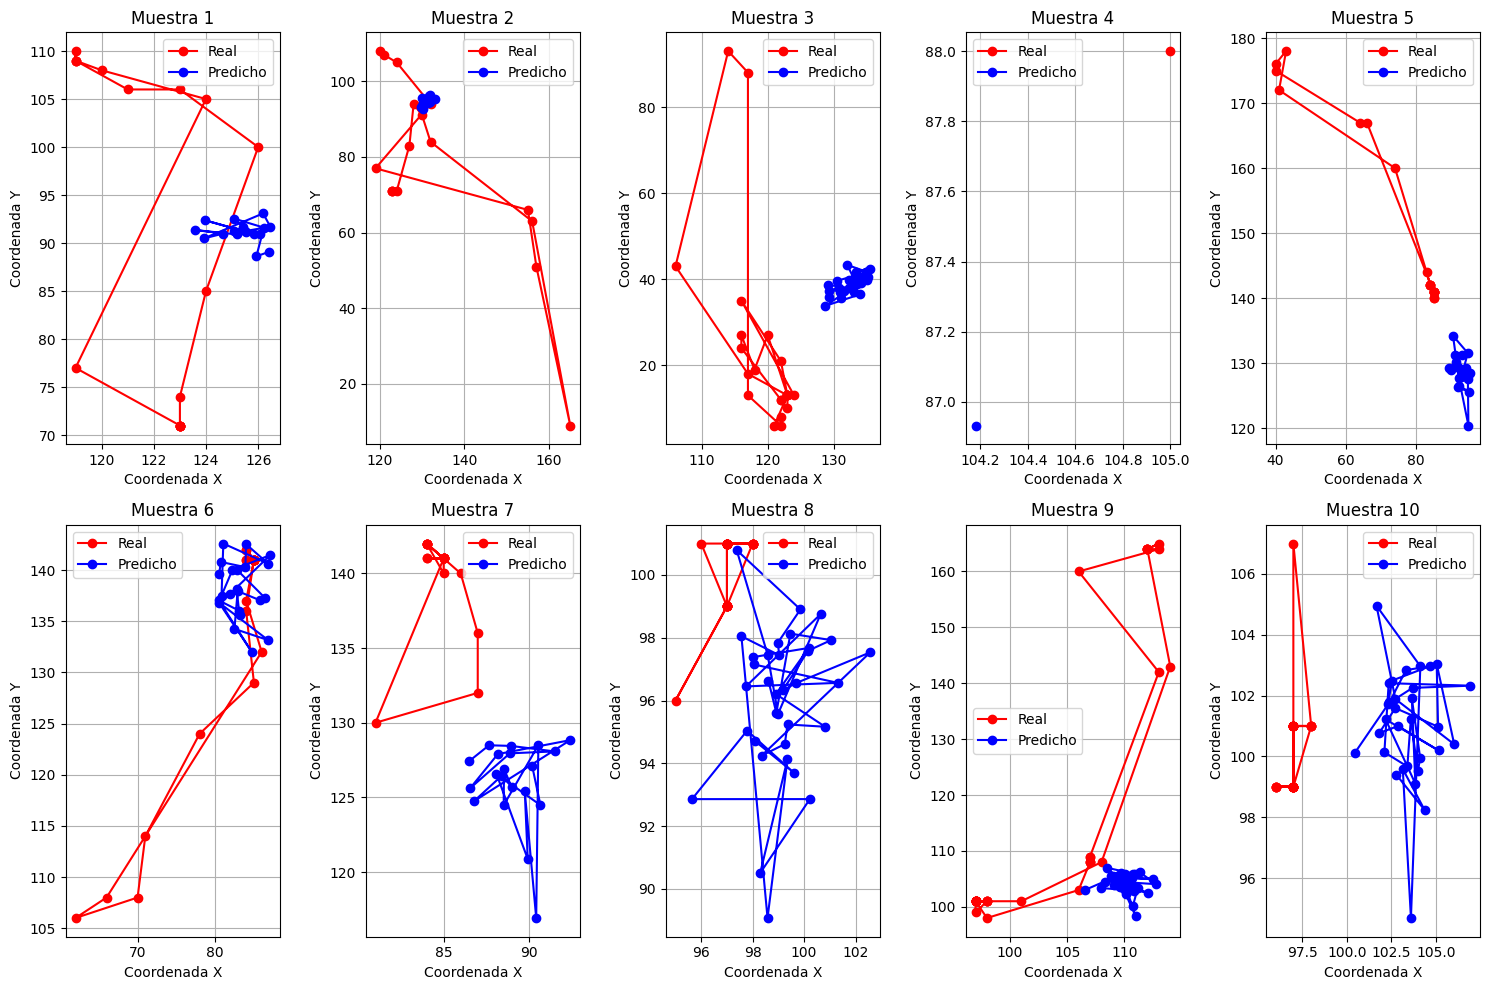

In [14]:
plot_predictions(predictions, targets, num_samples=10, num_columns=5)

In [15]:
# Cargar el modelo completo
model = torch.load(model_path)
model.eval()  # Configurar el modelo en modo evaluación

print("Modelo cargado correctamente desde 'simple_nn_complete.pth'.")

Modelo cargado correctamente desde 'simple_nn_complete.pth'.


C:\Users\Brian_iq\AppData\Local\Temp\ipykernel_28128\2703897339.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [31]:
# Evaluar el modelo con el DataLoader de prueba
from utils.metrics import DTWMetric, GeoBLEUMetric, LPPMetric, MAEMetric, Metric


def evaluate_metrics(
    model, dataloader, scaler, metrics: list[Metric], seq_length=7, start_day=0
):
    """
    Evalúa el modelo usando los datos estructurados en DataLoaders y calcula métricas,
    utilizando clases de métricas.

    Args:
        model: Modelo entrenado.
        dataloader (DataLoader): DataLoader con los datos estructurados.
        scaler (MinMaxScaler): Escalador para desnormalizar los datos.
        metrics (list[Metric]): Lista de instancias de métricas.
        seq_length (int): Longitud de la ventana de entrada en días.
        start_day (int): Día inicial para la reconstrucción de (d, t).

    Returns:
        dict: Diccionario con las métricas calculadas.
    """
    model.eval()  # Configurar el modelo en modo evaluación
    device = next(model.parameters()).device

    predictions_per_user = []
    validation_per_user = []

    with torch.no_grad():
        day_counter = start_day  # Día inicial para la reconstrucción

        for batch_X, batch_y in dataloader:
            # Mover datos al dispositivo
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Predicciones del modelo
            outputs = model(batch_X)

            # Convertir las predicciones y referencias a numpy
            outputs_np = outputs.cpu().numpy()
            batch_y_np = batch_y.cpu().numpy()

            # Desnormalizar los datos
            outputs_denorm = scaler.inverse_transform(
                outputs_np.reshape(-1, 2)
            ).reshape(outputs_np.shape)
            targets_denorm = scaler.inverse_transform(
                batch_y_np.reshape(-1, 2)
            ).reshape(batch_y_np.shape)

            # Reestructurar los datos en el formato (d, t, x, y) excluyendo puntos donde (x, y) = (0, 0)
            for pred, target in zip(outputs_denorm, targets_denorm):
                predicted_traj = []
                actual_traj = []

                for t, (pred_point, target_point) in enumerate(zip(pred, target)):
                    # Ignorar puntos donde el target es (0, 0)
                    if not (target_point[0] == 0 and target_point[1] == 0):
                        predicted_traj.append(
                            (day_counter, t, round(pred_point[0]), round(pred_point[1]))
                        )
                        actual_traj.append(
                            (
                                day_counter,
                                t,
                                round(target_point[0]),
                                round(target_point[1]),
                            )
                        )

                if predicted_traj and actual_traj:  # Solo agregar si hay datos válidos
                    predictions_per_user.append(predicted_traj)
                    validation_per_user.append(actual_traj)

                # Incrementar el contador del día
                day_counter += 1

    # Calcular métricas utilizando las clases
    results = {}
    for metric in metrics:
        print(f"Calculando métrica: {metric.__class__.__name__}")
        score = metric.calculate(predictions_per_user, validation_per_user)
        results[metric.__class__.__name__] = score

    return results

In [ ]:
metrics_instances: list[Metric] = [
    LPPMetric(),
    MAEMetric(),
    GeoBLEUMetric(),
    DTWMetric(),
]

results = evaluate_metrics(model, test_loader, scaler, metrics_instances, start_day=60)

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score}")

# Calculando métrica: LPPMetric
# Calculando métrica: MAEMetric
# Calculando métrica: GeoBLEUMetric
# Calculando métrica: DTWMetric
# Resultados de las Métricas:
# LPPMetric score: 3.84
# MAEMetric score: 22.52
# GeoBLEUMetric score: 6.503258794048911e-05
# DTWMetric score: 115.88

Resultados de las Métricas:
LPPMetric score: 3.84
MAEMetric score: 22.52
GeoBLEUMetric score: 6.503258794048911e-05
DTWMetric score: 115.88


In [32]:
metrics_instances: list[Metric] = [
    # LPPMetric(),
    # MAEMetric(),
    GeoBLEUMetric(),
    # DTWMetric(),
]

results = evaluate_metrics(model, test_loader, scaler, metrics_instances, start_day=60)

# Mostrar resultados
print("Resultados de las Métricas:")
for metric_name, score in results.items():
    print(f"{metric_name} score: {score:.2f}")

# Calculando métrica: LPPMetric
# Calculando métrica: MAEMetric
# Calculando métrica: GeoBLEUMetric
# Calculando métrica: DTWMetric
# Resultados de las Métricas:
# LPPMetric score: 3.84
# MAEMetric score: 22.52
# GeoBLEUMetric score: 0.00
# DTWMetric score: 115.88

Calculando métrica: GeoBLEUMetric


KeyboardInterrupt: 